In [2]:
%load_ext autoreload
%autoreload 2

In [57]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

sys.path.append('..')

from utils.dataset import DatasetReader

# Visualizing dataset 1

In [4]:
dr = DatasetReader(dataset=1, dataset_path='../temp/PUC_DIR')

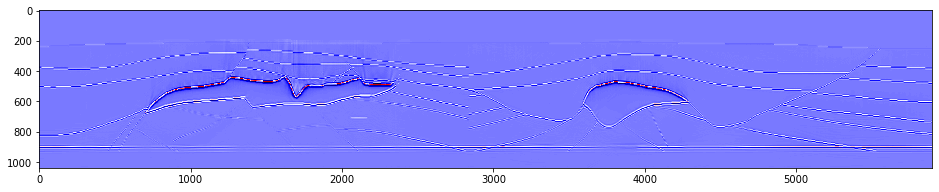

In [5]:
plt.imshow(dr.well, cmap='seismic')

# Visualizing dataset 2

In [6]:
dr2 = DatasetReader(dataset=2, dataset_path='../temp/PUC_DIR')

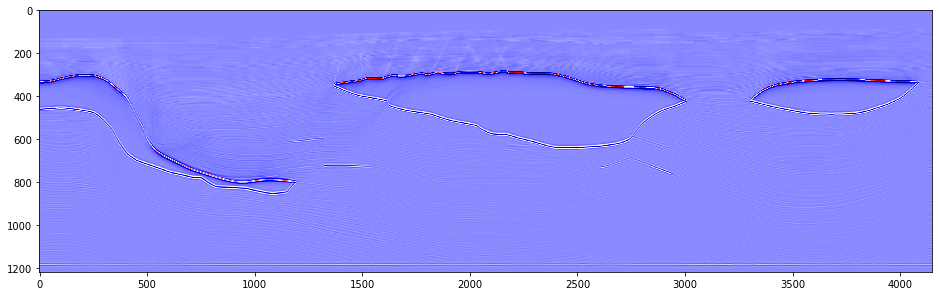

In [8]:
plt.imshow(dr2.well, cmap='seismic')

# Split in 50, 20, 30

In [9]:
shape = (64*(dr.well.shape[0]//64), 64*(dr.well.shape[1]//64))
shape

(1024, 5888)

In [13]:
train_split1 = round(shape[1]*.5)
val_split1 = round(shape[1]*.7)
test_split1 = shape[1]

train_split1, val_split1, test_split1

(2944, 4122, 5888)

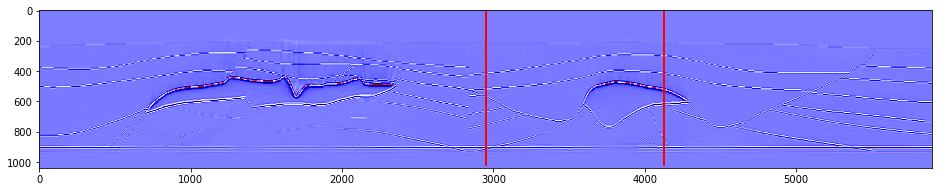

In [28]:
fig,ax = plt.subplots(1)
ax.imshow(dr.well, cmap='seismic')

train_line = patches.Rectangle([train_split, 0], 
                         5, shape[0], linewidth=1, edgecolor='r', facecolor='none')
val_line = patches.Rectangle([val_split, 0], 
                         5, shape[0], linewidth=1, edgecolor='r', facecolor='none')

ax.add_patch(train_line)
ax.add_patch(val_line)

plt.show()

In [22]:
shape2 = (64*(dr2.well.shape[0]//64), 64*(dr2.well.shape[1]//64))
train_split2 = round(shape2[1]*.5)
val_split2 = round(shape2[1]*.7)
test_split2 = shape2[1]

train_split2, val_split2, test_split2

(2048, 2867, 4096)

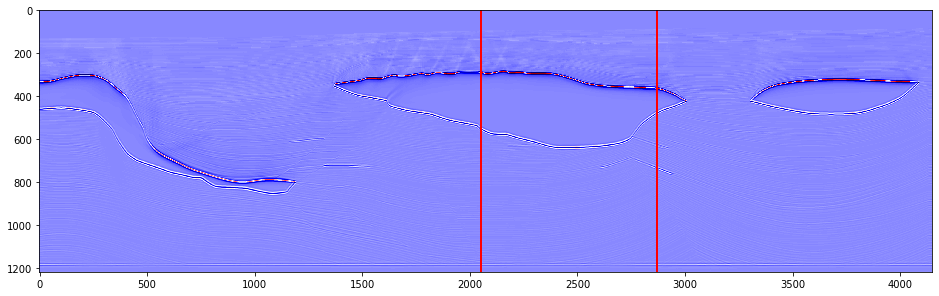

In [29]:
fig,ax = plt.subplots(1)
ax.imshow(dr2.well, cmap='seismic')

train_line = patches.Rectangle([train_split2, 0], 
                         5, shape2[0], linewidth=1, edgecolor='r', facecolor='none')
val_line = patches.Rectangle([val_split2, 0], 
                         5, shape2[0], linewidth=1, edgecolor='r', facecolor='none')

ax.add_patch(train_line)
ax.add_patch(val_line)

plt.show()

# Break into 64x64 imgs

In [30]:
data_coord_train1 = [(64*i, 64*j) for i in range(shape[0]//64) for j in range(train_split1//64)]
len(data_coord_train1), data_coord_train1[-1]

(736, (960, 2880))

In [31]:
data_coord_train2 = [(64*i, 64*j) for i in range(shape2[0]//64) for j in range(train_split2//64)]
len(data_coord_train2), data_coord_train2[-1]

(608, (1152, 1984))

In [32]:
data_coord_val1 = [(64*i, 64*j) for i in range(shape[0]//64) for j in range(train_split1//64, val_split1//64)]
len(data_coord_val1), data_coord_val1[-1]

(288, (960, 4032))

In [33]:
data_coord_val2 = [(64*i, 64*j) for i in range(shape2[0]//64) for j in range(train_split2//64, val_split2//64)]
len(data_coord_val2), data_coord_val2[-1]

(228, (1152, 2752))

# Downsampling image

In [39]:
from skimage.transform import rescale, resize, downscale_local_mean

In [41]:
img_size = 64
scale = 2

In [43]:
y_train = [dr.well[coord[0]: coord[0] + img_size, coord[1]: coord[1] + img_size] for coord in data_coord_train1]
y_train += [dr2.well[coord[0]: coord[0] + img_size, coord[1]: coord[1] + img_size] for coord in data_coord_train2]
x_train = [downscale_local_mean(y, (scale, scale)) for y in y_train]

len(x_train)

1344

In [46]:
y_val = [dr.well[coord[0]: coord[0] + img_size, coord[1]: coord[1] + img_size] for coord in data_coord_val1]
y_val += [dr2.well[coord[0]: coord[0] + img_size, coord[1]: coord[1] + img_size] for coord in data_coord_val2]
x_val = [downscale_local_mean(y, (scale, scale)) for y in y_val]

len(x_val)

516

In [47]:
scale = 4

In [49]:
x_train4 = [downscale_local_mean(y, (scale, scale)) for y in y_train]

len(x_train4)

1344

In [50]:
x_val4 = [downscale_local_mean(y, (scale, scale)) for y in y_val]

len(x_val4)

516

# Hist

In [62]:
std = []

for data in y_train+y_val:
    std.append(data.std())

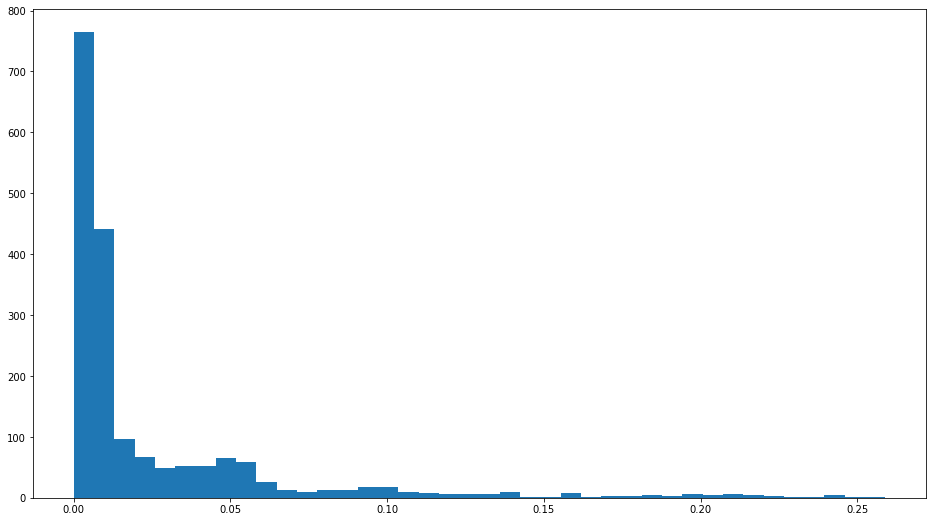

In [67]:
_ = plt.hist(std, bins=40)

In [68]:
df = pd.DataFrame(std)

In [70]:
df.describe()

,0
count,1860.000000
mean,0.024610
std,0.041282
min,0.000000
25%,0.001117
50%,0.008261
75%,0.028793
max,0.258866


# Baseline

In [53]:
def baseline(x, scale=2):
    return [rescale(img, scale, anti_aliasing=False) for img in x]

In [55]:
y_train_pred = baseline(x_train)
y_val_pred = baseline(x_val)

y_train_pred4 = baseline(x_train4, scale=4)
y_val_pred4 = baseline(x_val4, scale=4)

In [51]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse

def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [58]:
mse_sum = 0
ssim_sum = 0
psnr_sum = 0

for i in range(len(y_train)):
    mse_sum += mse(y_train[i], y_train_pred[i])
    ssim_sum += ssim(y_train[i], y_train_pred[i])
    psnr_sum += psnr(y_train[i], y_train_pred[i])

print(f"Mean MSE {mse_sum/len(y_train)}")
print(f"Mean SSIM {ssim_sum/len(y_train)}")
print(f"Mean PSNR {psnr_sum/len(y_train)}")

Mean MSE 9.085753231255324e-05
Mean SSIM 0.995390594817661
Mean PSNR 58.28982864419671


In [59]:
mse_sum = 0
ssim_sum = 0
psnr_sum = 0

for i in range(len(y_val)):
    mse_sum += mse(y_val[i], y_val_pred[i])
    ssim_sum += ssim(y_val[i], y_val_pred[i])
    psnr_sum += psnr(y_val[i], y_val_pred[i])

print(f"Mean MSE {mse_sum/len(y_val)}")
print(f"Mean SSIM {ssim_sum/len(y_val)}")
print(f"Mean PSNR {psnr_sum/len(y_val)}")

Mean MSE 9.9148426900003e-05
Mean SSIM 0.9961330570312595
Mean PSNR 60.891236017682495


In [61]:
mse_sum = 0
ssim_sum = 0
psnr_sum = 0

for i in range(len(y_train)):
    mse_sum += mse(y_train[i], y_train_pred4[i])
    ssim_sum += ssim(y_train[i], y_train_pred4[i])
    psnr_sum += psnr(y_train[i], y_train_pred4[i])

print(f"Mean MSE {mse_sum/len(y_train)}")
print(f"Mean SSIM {ssim_sum/len(y_train)}")
print(f"Mean PSNR {psnr_sum/len(y_train)}")

Mean MSE 0.0006720684959434405
Mean SSIM 0.9594622529064422
Mean PSNR 51.354698463492575


In [60]:
mse_sum = 0
ssim_sum = 0
psnr_sum = 0

for i in range(len(y_val)):
    mse_sum += mse(y_val[i], y_val_pred4[i])
    ssim_sum += ssim(y_val[i], y_val_pred4[i])
    psnr_sum += psnr(y_val[i], y_val_pred4[i])

print(f"Mean MSE {mse_sum/len(y_val)}")
print(f"Mean SSIM {ssim_sum/len(y_val)}")
print(f"Mean PSNR {psnr_sum/len(y_val)}")

Mean MSE 0.0006709890587701788
Mean SSIM 0.9661400030493209
Mean PSNR 53.79302685331613
